In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
%matplotlib inline

# Attributed graphs in NetworkX

In [1]:
import networkx as nx
import igraph as ig
import numpy as np
import glob
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns; sns.set_style('white')
import sys; sys.path.append('../')
from time import time
import logging
from anytree import LevelOrderIter
from statistics import mean
import os
import pickle

In [2]:
from VRG.src.utils import nx_to_igraph, check_file_exists
from VRG.src.graph_stats import GraphStats
from VRG.src.graph_comparison import GraphPairCompare
from VRG.runner import get_clustering
from VRG.src.Tree import create_tree, dasgupta_cost
from VRG.src.MDL import graph_dl as graph_mdl

sys path:  ['/home/jupyter-ssikdar/Attributed-VRG/notebooks', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python37.zip', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7/lib-dynload', '', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7/site-packages', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7/site-packages/IPython/extensions', '/home/jupyter-ssikdar/.ipython', '../', './../', './../../']


In [3]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

In [4]:
def load_pickle(fname):
#     logging.error(f'Reading {fname!r}')
    return pickle.load(open(fname, 'rb'))

In [5]:
def un_nest_attr_dict(g):
    new_g = nx.Graph()
    for n, d in g.nodes(data=True):
        while 'attr_dict' in d:
            d = d['attr_dict']
        new_g.add_node(n, **d)
    new_g.add_edges_from(g.edges())
    return new_g

In [19]:
def get_graph(gname: str = 'sample'):
    start_time = time()
    attr_name = ''
    if gname == 'sample':
        g = nx.Graph()
        g.add_nodes_from(range(5), color='blue')
        g.add_nodes_from(range(5, 9), color='red')

        g.add_edges_from([(0, 1), (0, 3), (0, 4),
                          (1, 2), (1, 4), (1, 5),
                          (2, 3), (2, 4), (2, 8),
                          (3, 4),
                          (5, 6), (5, 7), (5, 8),
                          (6, 7), (6, 8),
                          (7, 8)])  # properly labeled
        g.name = 'sample'
        attr_name = 'color'
    elif gname == 'karate':
        g = nx.karate_club_graph()
        attr_name = 'club'
        g.name = 'karate'
    elif gname == 'BA':
        g = nx.barabasi_albert_graph(10, 2, seed=42)
        # g = nx.MultiGraph(g)
        g = nx.Graph()
    elif gname.endswith('.gpickle'):
        g = nx.read_gpickle(gname)
        g.name = Path(gname).stem
    else:
        if gname in ('waterloo', 'grenoble', 'uppsala'):
            g = nx.read_gpickle(f'../snap_data/cleaned/{gname}_lcc_attr.gpickle')
        elif gname in ('polblogs', 'polbooks', 'football', 'bipartite-10-10', 'us-flights',
                       'cora', 'citeseer', 'pubmed'):
            g = nx.read_gml(f'../VRG/input/{gname}.gml')
            attr_name = 'value'
        else:
            path = f'../VRG/input/{gname}.g'
            g = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())

        g.remove_edges_from(nx.selfloop_edges(g))
        if not nx.is_connected(g):
            nodes_lcc = max(nx.connected_components(g), key=len)
            g = g.subgraph(nodes_lcc).copy()
        name = g.name
        g = nx.convert_node_labels_to_integers(g, label_attribute='orig_label')
        g.name = name

    end_time = round(time() - start_time, 2)
    logging.error(f'Graph: {gname}, n = {g.order():_d}, m = {g.size():_d}, read in {round(end_time, 3):_g}s.')

    return g, attr_name

In [7]:
def get_clustering(g: nx.Graph, outdir: str, clustering: str, use_pickle: bool, max_size=None):
    """
    wrapper method for getting dendrogram. uses an existing pickle if it can.
    :param g: graph
    :param outdir: output directory where picles are stored
    :param clustering: name of clustering method
    :param use_pickle: flag to whether or not to use the pickle
    :return: root node of the dendrogram
    """
    if g.name == 'sample':
        list_of_list_clusters = [
            [
                [[0], [1]],
                [[2], [[3], [4]]]
            ],
            [
                [[5], [6]],
                [[7], [8]]
            ]
        ]
        return list_of_list_clusters

    list_of_list_filename = os.path.join(outdir, f'{clustering}_list.pkl')

    if not os.path.exists(f'./{outdir}'):
        os.makedirs(f'./{outdir}')

    if check_file_exists(list_of_list_filename) and use_pickle:
        logging.error(f'Using existing pickle for {clustering!r} clustering\n')
        list_of_list_clusters = load_pickle(list_of_list_filename)

    else:
        tqdm.write(f'Running {clustering!r} clustering...')
        if clustering == 'random':
            list_of_list_clusters = partitions.get_random_partition(g)
        elif clustering == 'consensus':
            # delete the matlab tree and sc files
            matlab_files_path = './src/matlab_clustering/HierarchicalConsensus/data'
            tree_path = os.path.join(matlab_files_path, f'{g.name}_tree.mat')
            sc_path = os.path.join(matlab_files_path, f'{g.name}_sc.vec')
            if check_file_exists(tree_path):
                os.remove(tree_path)
            if check_file_exists(sc_path):
                os.remove(sc_path)
            list_of_list_clusters = get_consensus_root(g=g, gname=g.name)
        elif clustering in ('leiden', 'louvain', 'infomap', 'labelprop'):
            if max_size is None: max_size = g.order()
            list_of_list_clusters = partitions.louvain_leiden_infomap_label_prop(g, method=clustering, max_size=max_size)
        elif clustering == 'cond':
            list_of_list_clusters = partitions.approx_min_conductance_partitioning(g)
        elif clustering == 'spectral':
            list_of_list_clusters = partitions.spectral_kmeans(g, K=int(math.sqrt(g.order() // 2)))
        else:
            raise NotImplementedError(f'Invalid clustering algorithm {clustering!r}')
        dump_pickle(list_of_list_clusters, list_of_list_filename)

    return list_of_list_clusters

In [8]:
def plot_graph(g, ax=None, title='', attr_name='', mixing_dict={}):
    if attr_name != '' and len(mixing_dict) == 0:
        mixing_dict = nx.attribute_mixing_dict(g, attr_name)
        
    unique_values = set(mixing_dict.keys())
    colors = sns.color_palette('pastel', n_colors=len(unique_values))
    color_map = {val: col for val, col in zip(unique_values, colors)}

    try:
        colors = [color_map[d[attr_name]] for _, d in g.nodes(data=True)]
    except KeyError:
        colors = '#77dd77'
    pos = nx.spring_layout(g)

    if ax is not None:
        ax.set_title(title, fontsize=20)
    nx.draw_networkx_nodes(g, pos=pos, node_size=100, node_color=colors, alpha=0.95, ax=ax)
    nx.draw_networkx_edges(g, pos=pos, edge_color='gray', alpha=0.7, ax=ax)
    return

In [9]:
def grid_plot(graphs, graph_name='', attr_name='', mixing_dict={}):
    # todo keep the positions of the constant nodes fixed
    rows, cols = 2, 4
    plt.rcParams['figure.figsize'] = [30, 15]

    grid = gridspec.GridSpec(rows, cols)
    fig = plt.figure()
    for i, box in enumerate(grid):
        ax = fig.add_subplot(box)
        g = graphs[i]
        deg_as = round(nx.degree_assortativity_coefficient(g), 3)
        attr_as = round(nx.attribute_assortativity_coefficient(g, attribute=attr_name), 3)
        title = f'g{i + 1} {g.order(), g.size()} degree as: {deg_as} {attr_name} as: {attr_as}'
        plot_graph(g, ax=ax, title=title, mixing_dict=mixing_dict, attr_name=attr_name)

    plt.tight_layout()
    plt.suptitle(f'{graph_name}', y=1, fontsize=25)

In [10]:
def read_cabam_graphs():
    cabam_input_graphs = load_pickle('/data/ssikdar/attributed-vrg/cabam.graphs')
    cleaned_graphs = []

    for g in cabam_input_graphs:
        g.remove_edges_from(nx.selfloop_edges(g))
        if not nx.is_connected(g):
            nodes_lcc = max(nx.connected_components(g), key=len)
            g = g.subgraph(nodes_lcc).copy()
        g = nx.convert_node_labels_to_integers(g, label_attribute='orig_label')
        g.name = 'CABAM'
        cleaned_graphs.append(g)

    return cleaned_graphs

In [11]:
def get_tree_stats(g, root):
    """
    Compute height of the tree, avg branching factor, dasgupta cost
    """
    ht = root.height
    avg_branch_factor = mean(len(node.children) for node in LevelOrderIter(root) if len(node.children) > 1)
    dc = dasgupta_cost(g, root)
    return ht, avg_branch_factor, dc

In [12]:
def get_compatibility_matrix(g: nx.Graph, attr_name: str):
    """
    From Danai's heterophily paper
    :param g:
    :param attr_name:
    :return:
    """
    values = set(nx.get_node_attributes(g, attr_name).values())
    mapping = {val: i for i, val in enumerate(values)}
#     print(mapping)
    C = nx.attribute_mixing_matrix(g, attribute=attr_name, mapping=mapping, normalized=False)
    np.fill_diagonal(C, C.diagonal() / 2)

    D = np.diag(np.diag(C))
    e = np.ones(shape=(len(mapping), 1))

    h = float((e.T @ D @ e) / (e.T @ C @ e))
    H = np.nan

#     Y = np.zeros(shape=(g.order(), len(mapping)))
#     for n, d in g.nodes(data=True):
#         attr = d[attr_name]
#         Y[n, mapping[attr]] = 1
#     A = nx.adjacency_matrix(g)
#     E = np.ones(shape=(A.shape[0], len(mapping)))

#     H = (Y.T @ A @ Y) / (Y.T @ A @ E)

    return_d = dict(homophily_ratio=h, compatibility_mat=H, attr_name=attr_name, mapping=mapping)
    return return_d

In [67]:
def make_graph_df(name, fname, orig_graph, mu, clustering, attr_name, grammar_type):
    deg_ast_fn = nx.degree_assortativity_coefficient
    attr_ast_fn = nx.attribute_assortativity_coefficient
    
    gen_graphs = load_pickle(fname)
    
    cols = ['name', 'orig_n', 'orig_m', 'orig_degree_ast', 'attr_name', 'orig_attr_ast', 
            'model', 'mu', 'clustering', 'gen_n', 'gen_m', 'gen_degree_ast', 'gen_attr_ast', 
            'total_rewired_edges', 'fancy_rewired_edges',
            'degree_js', 'pagerank_js', 'lambda_dist', 'deg_ast_diff', 'attr_ast_diff']
    
    row = {col: np.nan for col in cols}
    
    orig_deg_ast = deg_ast_fn(orig_graph)
    orig_attr_ast = attr_ast_fn(orig_graph, attr_name) if attr_name != '' else np.nan
    orig_gstats = GraphStats(orig_graph)
    orig_homophily_ratio = get_compatibility_matrix(orig_graph, attr_name)['homophily_ratio']
    rows = []
    
    for g in gen_graphs[: 20]:
        g = un_nest_attr_dict(g)
        gen_gstats = GraphStats(g)
        gpc = GraphPairCompare(orig_gstats, gen_gstats)
        gen_deg_ast = deg_ast_fn(g)
        gen_attr_ast = attr_ast_fn(g, attr_name) if attr_name != '' else np.nan
        total_rewired_edges = g.graph.get('total_rewirings', 0)
        fancy_rewired_edges = g.graph.get('fancy_rewirings', 0)
        h = get_compatibility_matrix(g, attr_name)['homophily_ratio']
        
        row = {'name': name, 'orig_n': orig_graph.order(), 'orig_m': orig_graph.size(), 
               'orig_degree_ast': deg_ast_fn(orig_graph), 'attr_name': attr_name, 
               'orig_attr_ast': orig_attr_ast, 'model': grammar_type, 
               'clustering': clustering, 'mu': mu, 'orig_homophily_ratio': orig_homophily_ratio,
               'gen_n': g.order(), 'gen_m': g.size(), 'gen_degree_ast': gen_deg_ast, 'gen_attr_ast': gen_attr_ast, 
               'total_rewired_edges': total_rewired_edges, 'fancy_rewired_edges': fancy_rewired_edges,
               'degree_js': gpc.degree_js(), 'pagerank_js': gpc.pagerank_js(), 'lambda_dist': gpc.lambda_dist(), 
               'deg_ast_diff': np.abs(orig_deg_ast - gen_deg_ast), 'attr_ast_diff': np.abs(orig_attr_ast - gen_attr_ast),
               'gen_homophily_ratio': h
              }
        
        rows.append(row)
    
    return pd.DataFrame(rows)

In [ ]:
def make_grammar_df(names=None, graphs=None):
    if names is None:
        names = ['karate', 'football', 'polbooks', 'polblogs', 'cora', 'citeseer', 'pubmed'][: -1]

#     frac = np.linspace(0, 1, 21, endpoint=True) * 100
#     names = [f'3-comm-{int(f)}' for f in frac]
#     shuffle = 'edges'
    rows = []

#     root_dict = {f'{name}-{shuffle}': {} for name in names}
    root_dict = {f'{name}': {} for name in names}
    dl_dict = {}
    
    for name in names:
#         orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/{shuffle}/{name}.gexf'), 'block'
#         name = f'{name}-{shuffle}'
        orig_graph, attr_name = get_graph(name)
        dl_dict[name] = graph_mdl(orig_graph)
        if attr_name != '':
            dl_dict[name] = graph_mdl(orig_graph, attributed=True)
    print(dl_dict)
    
    for name in names:
        orig_graph, attr_name = get_graph(name)        
#         orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/{shuffle}/{name}.gexf'), 'block'
#         name = f'{name}-{shuffle}'
        print('\n\n', name, attr_name)
        for fname in glob.glob(f'/data/ssikdar/attributed-vrg/dumps/grammars/{name}/*.pkl'):
            path = Path(fname)
            pattern = r'(.*)\_(\w+)\_(\d+)\_(\d+)'
            m = re.match(pattern, path.stem)
            grammar_type, clustering, mu, _ = m.groups()
            
            print(grammar_type, clustering, mu, end='\t', flush=True)
            
            if clustering in root_dict[name]:
                ht, avg_branch_factor, dc = root_dict[name][clustering]
            else:
                root = load_pickle(f'/data/ssikdar/attributed-vrg/dumps/trees/{name}/{clustering}_list.pkl')
                if isinstance(root, list): root = create_tree(root)
                ht, avg_branch_factor, dc = get_tree_stats(g=orig_graph, root=root)
                root_dict[name][clustering] = ht, avg_branch_factor, dc

            vrg = load_pickle(fname)
#             if grammar_type.startswith('AVRG'): name = f'{name}-attr'
            graph_dl = dl_dict[name]
            
            row = dict(name=name, orig_n=orig_graph.order(), orig_m=orig_graph.size(), attr_name=attr_name, 
                      model=grammar_type, mu=int(mu), clustering=clustering, cost=dc, branch_factor=avg_branch_factor,
                      height=ht, graph_dl=graph_dl, num_rules=vrg.num_rules, unique_rules=len(vrg.unique_rule_list),
                      grammar_dl=vrg.cost)
            name = name.replace('-attr', '')
            rows.append(row)

    return pd.DataFrame(rows)

In [ ]:
def make_cabam_grammar_df(names=None, graphs=None):
    cabam_graphs = read_cabam_graphs()
    rows = []

    root_dict = {f'{name}': {} for name in names}
    dl_dict = {}
    
    for name in names:
#         orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/{shuffle}/{name}.gexf'), 'block'
#         name = f'{name}-{shuffle}'
        orig_graph, attr_name = get_graph(name)
        dl_dict[name] = graph_mdl(orig_graph)
        if attr_name != '':
            dl_dict[name] = graph_mdl(orig_graph, attributed=True)
    print(dl_dict)
    
    for name in names:
        orig_graph, attr_name = get_graph(name)        
#         orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/{shuffle}/{name}.gexf'), 'block'
#         name = f'{name}-{shuffle}'
        print('\n\n', name, attr_name)
        for fname in glob.glob(f'/data/ssikdar/attributed-vrg/dumps/grammars/{name}/*.pkl'):
            path = Path(fname)
            pattern = r'(.*)\_(\w+)\_(\d+)\_(\d+)'
            m = re.match(pattern, path.stem)
            grammar_type, clustering, mu, _ = m.groups()
            
            print(grammar_type, clustering, mu, end='\t', flush=True)
            
            if clustering in root_dict[name]:
                ht, avg_branch_factor, dc = root_dict[name][clustering]
            else:
                root = load_pickle(f'/data/ssikdar/attributed-vrg/dumps/trees/{name}/{clustering}_list.pkl')
                if isinstance(root, list): root = create_tree(root)
                ht, avg_branch_factor, dc = get_tree_stats(g=orig_graph, root=root)
                root_dict[name][clustering] = ht, avg_branch_factor, dc

            vrg = load_pickle(fname)
#             if grammar_type.startswith('AVRG'): name = f'{name}-attr'
            graph_dl = dl_dict[name]
            
            row = dict(name=name, orig_n=orig_graph.order(), orig_m=orig_graph.size(), attr_name=attr_name, 
                      model=grammar_type, mu=int(mu), clustering=clustering, cost=dc, branch_factor=avg_branch_factor,
                      height=ht, graph_dl=graph_dl, num_rules=vrg.num_rules, unique_rules=len(vrg.unique_rule_list),
                      grammar_dl=vrg.cost)
            name = name.replace('-attr', '')
            rows.append(row)

    return pd.DataFrame(rows)

In [ ]:
%%time
grammar_df = make_grammar_df()

In [ ]:
grammar_df.to_csv('./grammar_df.csv')

In [ ]:
grammar_df = pd.read_csv('/data/ssikdar/attributed-vrg/data/grammar_df.csv')

In [ ]:
display(grammar_df.head(), grammar_df.shape)

In [ ]:
grammar_df.describe()

In [ ]:
ax = plt.gca()
ax.set_yscale('log')
sns.barplot(x='name', y='grammar_dl', hue='model', data=grammar_df, ax=ax);

In [ ]:
grammar_df['compression'] = grammar_df['graph_dl'] / grammar_df['grammar_dl']

In [ ]:
grammar_df.model.unique()

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

In [ ]:
ax = plt.gca()
ax.set_yscale('log')
ax.axhline(1, c='r')
sns.barplot(x='model', y='compression', hue='clustering', data=grammar_df);
ax.set_ylabel('Compression Ratio');

In [ ]:
sns.barplot(x='name', y='compression', hue='clustering', data=grammar_df);

In [ ]:
ax = plt.gca()
ax.set_yscale('log')
# ax.axhline(1, c='r')
sns.barplot(x='name', y='grammar_dl', hue='model', data=grammar_df);
# ax.set_ylabel('Compression Ratio');

In [ ]:
ax = plt.gca()
ax.set_yscale('log')
# ax.axhline(1, c='r')
sns.barplot(x='name', y='compression', hue='clustering', data=grammar_df);
# ax.set_ylabel('Compression Ratio');

In [ ]:
ax = plt.gca()
ax.set_yscale('log')
# ax.axhline(1, c='r')
sns.barplot(x='name', y='unique_rules', hue='mu', data=grammar_df[~grammar_df.model.str.contains('all-tnodes')]);
# ax.set_ylabel('Compression Ratio');

In [ ]:
ax = plt.gca()
ax.set_yscale('log')
sns.barplot(x='name', y='grammar_dl', hue='model', data=grammar_df);

In [ ]:
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
sns.scatterplot(x='cost', y='compression', hue='clustering', data=grammar_df,
                s=100, alpha=0.6);
ax.set_xlabel('Log (Dasgupta Cost)');
ax.set_ylabel('Log (Compression Ratio)');

In [ ]:
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
sns.scatterplot(x='cost', y='compression', hue='mu', style='name', data=grammar_df,
               s=100, alpha=0.6);
ax.set_xlabel('Log (Dasgupta Cost)');
ax.set_ylabel('Log (Compression Ratio)');

In [ ]:
grammar_df['log_compression'] = grammar_df['compression'].apply(np.log10)

In [ ]:
sns.catplot(x='mu', y='num_rules', hue='clustering', col='name', kind='bar', data=grammar_df, col_wrap=3);

## Do stuff with the final graphs

In [68]:
names = ['karate', 'football', 'polbooks', 'us-flights', 'cora', 'citeseer', 'polblogs', 
         'pubmed'][: -1]
mus = [5, 6]
clusterings = ['cond', 'leiden', 'spectral', 'consensus']
dfs = []

for name in names:
    orig_graph, attr_name = get_graph(name)
#     orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/{shuffle}/{name}.gexf', node_type=int), 'block'
#     name = f'{name}-{shuffle}'
    print(name)
    for fname in glob.glob(f'/data/ssikdar/attributed-vrg/dumps/graphs/{name}/*'):
        path = Path(fname)
        stem = path.stem
        if stem.startswith('Chung'):
            grammar_type, clustering, mu = 'Chung-Lu', np.nan, np.nan
        elif stem.startswith('SBM'):
            grammar_type, clustering, mu = 'SBM', np.nan, np.nan
        else:
            pattern = r'(.*)\_(\w+)\_(\d+)\_(\d+)'
            m = re.match(pattern, stem)
            grammar_type, clustering, mu, _ = m.groups()
            mu = int(mu)
            if clustering not in clusterings or mu not in mus:
                continue
        print(path.stem, end='\t', flush=True)

        df = make_graph_df(name, fname, orig_graph, mu, clustering, attr_name, grammar_type)
        dfs.append(df)
graph_df = pd.concat(dfs, ignore_index=True)

Graph: karate, n = 34, m = 78, read in 0s.


karate
VRG-50_cond_6_20	AVRG-fancy-50_cond_6_20	VRG-50_cond_5_20	VRG-50_spectral_5_20	AVRG-fancy-50_cond_5_20	AVRG-greedy-50_cond_6_20	AVRG-greedy-100_cond_6_20	AVRG-greedy-50_cond_5_20	AVRG-greedy-100_cond_5_20	VRG-50_spectral_6_20	AVRG-greedy-0_cond_5_20	AVRG-greedy-0_cond_6_20	VRG-50_leiden_6_20	AVRG-fancy-50_spectral_6_20	AVRG-fancy-50_spectral_5_20	AVRG-greedy-50_spectral_6_20	VRG-50_leiden_5_20	AVRG-fancy-50_leiden_6_20	AVRG-greedy-0_spectral_6_20	AVRG-greedy-100_spectral_6_20	AVRG-greedy-50_spectral_5_20	AVRG-greedy-100_spectral_5_20	AVRG-greedy-0_spectral_5_20	AVRG-fancy-50_leiden_5_20	AVRG-greedy-50_leiden_6_20	AVRG-greedy-0_leiden_6_20	AVRG-greedy-100_leiden_6_20	AVRG-greedy-50_leiden_5_20	VRG-50_consensus_6_20	AVRG-fancy-50_consensus_6_20	AVRG-greedy-0_leiden_5_20	AVRG-greedy-100_leiden_5_20	VRG-50_consensus_5_20	AVRG-greedy-50_consensus_6_20	AVRG-greedy-0_consensus_6_20	AVRG-greedy-100_consensus_6_20	AVRG-fancy-50_consensus_5_20	AVRG-greedy-50_consensus_5_20	AVRG-greedy-0_c

Graph: football, n = 115, m = 613, read in 0.05s.


football
VRG-50_spectral_5_20	VRG-50_cond_6_20	VRG-50_cond_5_20	AVRG-fancy-50_cond_5_20	AVRG-fancy-50_cond_6_20	VRG-50_spectral_6_20	AVRG-greedy-0_cond_5_20	AVRG-fancy-50_spectral_5_20	AVRG-greedy-50_cond_5_20	VRG-50_leiden_5_20	AVRG-fancy-50_spectral_6_20	AVRG-greedy-0_cond_6_20	AVRG-greedy-100_cond_5_20	AVRG-greedy-50_cond_6_20	AVRG-greedy-100_cond_6_20	AVRG-fancy-50_leiden_5_20	AVRG-greedy-0_spectral_5_20	AVRG-greedy-50_spectral_5_20	AVRG-greedy-100_spectral_5_20	VRG-50_leiden_6_20	AVRG-fancy-50_leiden_6_20	AVRG-greedy-0_spectral_6_20	AVRG-greedy-50_spectral_6_20	AVRG-greedy-100_spectral_6_20	VRG-50_consensus_6_20	VRG-50_consensus_5_20	AVRG-greedy-0_leiden_5_20	AVRG-fancy-50_consensus_5_20	AVRG-greedy-100_leiden_5_20	AVRG-greedy-50_leiden_5_20	AVRG-fancy-50_consensus_6_20	AVRG-greedy-0_consensus_5_20	AVRG-greedy-100_consensus_5_20	AVRG-greedy-50_consensus_5_20	AVRG-greedy-50_consensus_6_20	AVRG-greedy-0_consensus_6_20	AVRG-greedy-100_consensus_6_20	AVRG-greedy-0_leiden_6_20	AVRG-gre

Graph: polbooks, n = 105, m = 441, read in 0.04s.


polbooks
VRG-50_cond_6_20	VRG-50_spectral_5_20	VRG-50_spectral_6_20	VRG-50_cond_5_20	AVRG-fancy-50_cond_6_20	AVRG-fancy-50_cond_5_20	AVRG-greedy-0_cond_5_20	AVRG-fancy-50_spectral_5_20	AVRG-greedy-50_cond_5_20	AVRG-greedy-100_cond_5_20	AVRG-fancy-50_spectral_6_20	AVRG-greedy-50_cond_6_20	AVRG-greedy-0_cond_6_20	VRG-50_leiden_5_20	AVRG-greedy-100_cond_6_20	VRG-50_leiden_6_20	AVRG-greedy-50_spectral_5_20	AVRG-greedy-0_spectral_5_20	AVRG-fancy-50_leiden_5_20	AVRG-greedy-100_spectral_5_20	AVRG-greedy-50_spectral_6_20	AVRG-greedy-0_spectral_6_20	AVRG-fancy-50_leiden_6_20	AVRG-greedy-100_spectral_6_20	VRG-50_consensus_5_20	VRG-50_consensus_6_20	AVRG-greedy-0_leiden_5_20	AVRG-fancy-50_consensus_5_20	AVRG-greedy-100_leiden_5_20	AVRG-greedy-50_leiden_5_20	AVRG-fancy-50_consensus_6_20	AVRG-greedy-0_leiden_6_20	AVRG-greedy-100_leiden_6_20	AVRG-greedy-50_leiden_6_20	AVRG-greedy-50_consensus_5_20	AVRG-greedy-100_consensus_5_20	AVRG-greedy-0_consensus_5_20	AVRG-greedy-0_consensus_6_20	AVRG-greedy-50

Graph: us-flights, n = 535, m = 2_772, read in 0.27s.


us-flights
VRG_cond_6_10	AVRG-fancy_cond_6_10	VRG_cond_5_10	AVRG-fancy_cond_5_10	VRG_spectral_5_10	VRG_spectral_6_10	AVRG-greedy-0_cond_5_10	AVRG-greedy-50_cond_5_10	AVRG-fancy_spectral_5_10	AVRG-greedy-100_cond_5_10	AVRG-greedy-50_cond_6_10	AVRG-greedy-0_cond_6_10	AVRG-fancy_spectral_6_10	AVRG-greedy-100_cond_6_10	VRG_leiden_5_10	VRG_leiden_6_10	AVRG-fancy_leiden_5_10	AVRG-greedy-0_spectral_5_10	AVRG-greedy-50_spectral_5_10	AVRG-fancy_leiden_6_10	AVRG-greedy-50_leiden_5_10	AVRG-greedy-0_leiden_5_10	AVRG-greedy-100_spectral_5_10	AVRG-greedy-0_spectral_6_10	AVRG-greedy-50_spectral_6_10	AVRG-greedy-100_spectral_6_10	AVRG-greedy-100_leiden_5_10	AVRG-greedy-0_leiden_6_10	AVRG-greedy-50_leiden_6_10	AVRG-greedy-100_leiden_6_10	Chung-Lu_10	SBM_10	

Graph: cora, n = 2_485, m = 5_069, read in 0.6s.


cora
VRG-50_spectral_5_20	VRG-50_spectral_6_20	VRG-50_cond_6_20	AVRG-fancy-50_cond_6_20	VRG-50_cond_5_20	AVRG-fancy-50_cond_5_20	VRG-50_leiden_5_20	AVRG-fancy-50_spectral_5_20	VRG-50_leiden_6_20	AVRG-fancy-50_spectral_6_20	AVRG-fancy-50_leiden_5_20	AVRG-greedy-50_spectral_5_20	AVRG-fancy-50_leiden_6_20	AVRG-greedy-50_spectral_6_20	AVRG-greedy-50_cond_5_20	AVRG-greedy-50_cond_6_20	AVRG-fancy-50_consensus_5_20	AVRG-greedy-50_leiden_5_20	AVRG-greedy-50_leiden_6_20	AVRG-greedy-50_consensus_5_20	VRG_spectral_5_10	VRG_spectral_6_10	VRG_cond_6_10	AVRG-fancy_cond_6_10	VRG_cond_5_10	AVRG-fancy_cond_5_10	AVRG-greedy-50_cond_6_10	AVRG-greedy-0_cond_6_10	AVRG-greedy-100_cond_6_10	AVRG-greedy-0_cond_5_10	VRG_leiden_5_10	AVRG-fancy_spectral_5_10	AVRG-greedy-50_cond_5_10	VRG_leiden_6_10	AVRG-fancy_spectral_6_10	AVRG-greedy-100_cond_5_10	AVRG-greedy-0_spectral_5_10	AVRG-greedy-50_spectral_5_10	AVRG-greedy-100_spectral_5_10	AVRG-greedy-0_spectral_6_10	AVRG-greedy-50_spectral_6_10	AVRG-greedy-100_spectr

Graph: citeseer, n = 2_110, m = 3_668, read in 0.39s.


citeseer
VRG-50_spectral_5_20	VRG-50_spectral_6_20	VRG-50_cond_6_20	AVRG-fancy-50_cond_6_20	VRG-50_cond_5_20	AVRG-fancy-50_cond_5_20	VRG-50_leiden_5_20	AVRG-fancy-50_spectral_5_20	AVRG-fancy-50_spectral_6_20	VRG-50_leiden_6_20	AVRG-greedy-50_cond_6_20	AVRG-fancy-50_leiden_5_20	AVRG-fancy-50_leiden_6_20	AVRG-greedy-50_spectral_5_20	AVRG-greedy-50_cond_5_20	AVRG-greedy-50_spectral_6_20	AVRG-greedy-50_leiden_5_20	AVRG-greedy-50_leiden_6_20	VRG_spectral_5_10	VRG_spectral_6_10	VRG_cond_6_10	AVRG-fancy_cond_6_10	VRG_cond_5_10	AVRG-fancy_cond_5_10	AVRG-greedy-0_cond_6_10	AVRG-greedy-50_cond_6_10	AVRG-greedy-100_cond_6_10	VRG_leiden_5_10	AVRG-fancy_spectral_5_10	AVRG-greedy-0_spectral_5_10	AVRG-fancy_spectral_6_10	AVRG-greedy-50_spectral_5_10	AVRG-greedy-100_spectral_5_10	AVRG-greedy-0_cond_5_10	AVRG-greedy-50_cond_5_10	AVRG-greedy-0_spectral_6_10	AVRG-greedy-50_spectral_6_10	VRG_leiden_6_10	AVRG-greedy-100_spectral_6_10	AVRG-fancy_leiden_5_10	AVRG-greedy-100_cond_5_10	AVRG-fancy_leiden_6_10	A

Graph: polblogs, n = 1_222, m = 16_714, read in 1.32s.


polblogs
VRG-50_spectral_5_20	VRG-50_cond_6_20	AVRG-fancy-50_cond_6_20	VRG-50_cond_5_20	AVRG-fancy-50_cond_5_20	VRG-50_leiden_5_20	VRG-50_leiden_6_20	AVRG-fancy-50_leiden_5_20	VRG-50_spectral_6_20	AVRG-fancy-50_spectral_5_20	AVRG-fancy-50_spectral_6_20	AVRG-fancy-50_leiden_6_20	AVRG-greedy-50_cond_5_20	AVRG-greedy-50_cond_6_20	VRG-50_consensus_5_20	AVRG-fancy-50_consensus_5_20	AVRG-greedy-50_consensus_5_20	AVRG-fancy-50_consensus_6_20	AVRG-greedy-50_consensus_6_20	VRG-50_consensus_6_20	AVRG-greedy-50_leiden_5_20	AVRG-greedy-50_spectral_5_20	AVRG-greedy-50_spectral_6_20	AVRG-greedy-50_leiden_6_20	VRG_spectral_5_10	VRG_cond_6_10	AVRG-fancy_cond_6_10	AVRG-greedy-0_cond_6_10	VRG_cond_5_10	AVRG-fancy_cond_5_10	AVRG-greedy-50_cond_6_10	AVRG-greedy-100_cond_6_10	AVRG-greedy-0_cond_5_10	AVRG-greedy-50_cond_5_10	VRG_leiden_5_10	VRG_leiden_6_10	AVRG-greedy-100_cond_5_10	AVRG-fancy_leiden_5_10	VRG_spectral_6_10	AVRG-fancy_spectral_5_10	AVRG-greedy-0_leiden_5_10	AVRG-fancy_spectral_6_10	AVRG-greed

In [52]:
graph_df = pd.concat(dfs, ignore_index=True)

In [56]:
graph_df = graph_df[graph_df.model != 'AVRG']

In [57]:
graph_df.model.value_counts()

AVRG-greedy-50     1180
AVRG-fancy         1180
VRG                1160
AVRG-greedy-0       920
AVRG-greedy-100     920
SBM                  60
Chung-Lu             60
Name: model, dtype: int64

In [54]:
graph_df['model'].replace(['AVRG-fancy-50', 'VRG-50'], ['AVRG-fancy', 'VRG'], inplace=True)

In [58]:
graph_df.model.value_counts()

AVRG-greedy-50     1180
AVRG-fancy         1180
VRG                1160
AVRG-greedy-0       920
AVRG-greedy-100     920
SBM                  60
Chung-Lu             60
Name: model, dtype: int64

In [59]:
graph_df.head()

,name,orig_n,orig_m,orig_degree_ast,attr_name,orig_attr_ast,model,clustering,mu,orig_homophily_ratio,...,gen_degree_ast,gen_attr_ast,total_rewired_edges,fancy_rewired_edges,degree_js,pagerank_js,lambda_dist,deg_ast_diff,attr_ast_diff,gen_homophily_ratio
0,karate,34,78,-0.475613,club,0.717531,VRG,cond,6.0,0.752809,...,-0.416691,0.384397,0,0,0.245504,0.909704,0.22167,0.058922,0.333134,0.631579
1,karate,34,78,-0.475613,club,0.717531,VRG,cond,6.0,0.752809,...,-0.242907,0.311565,0,0,0.372049,0.562966,0.24672,0.232706,0.405966,0.540000
2,karate,34,78,-0.475613,club,0.717531,VRG,cond,6.0,0.752809,...,-0.289792,0.293585,0,0,0.357388,0.608235,0.22456,0.185821,0.423946,0.529412
3,karate,34,78,-0.475613,club,0.717531,VRG,cond,6.0,0.752809,...,-0.474728,0.387500,0,0,0.230574,0.881795,0.22643,0.000885,0.330031,0.636364
4,karate,34,78,-0.475613,club,0.717531,VRG,cond,6.0,0.752809,...,-0.411475,0.358234,0,0,0.204629,0.872102,0.21632,0.064138,0.359297,0.615385


In [60]:
graph_df.to_csv('./graph_df.csv')

In [ ]:
graph_df = pd.read_csv('/data/ssikdar/attributed-vrg/data/temp_graph_df.csv')

In [ ]:
display(graph_df.head(), graph_df.shape)

In [ ]:
graph_df.rename(columns={'lamda_dist': 'lambda_dist'}, inplace=True)

In [61]:
graph_df['degree_ast_diff'] = graph_df['orig_degree_ast'] - graph_df['gen_degree_ast']
graph_df['attr_ast_diff'] = graph_df['orig_attr_ast'] - graph_df['gen_attr_ast']

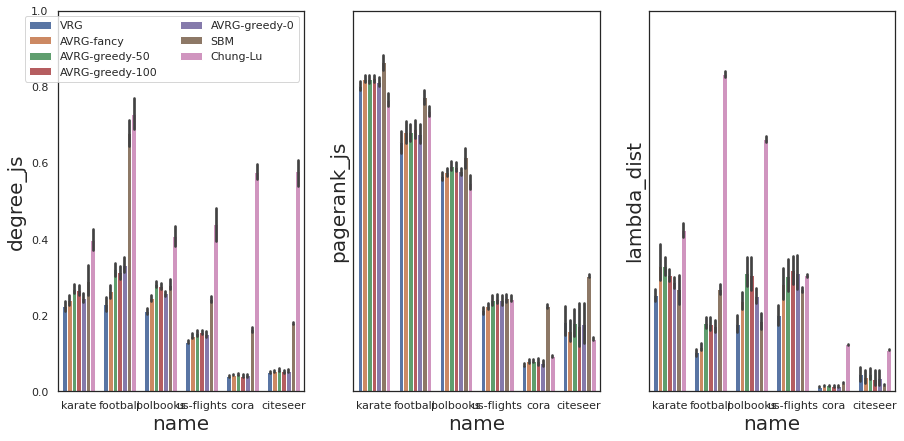

In [63]:
plt.rcParams['figure.figsize'] = (15, 7)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True)
sns.barplot(x='name', y='degree_js', hue='model', data=graph_df, ax=ax1);
sns.barplot(x='name', y='pagerank_js', hue='model', data=graph_df, ax=ax2);
sns.barplot(x='name', y='lambda_dist', hue='model', data=graph_df, ax=ax3);
ax1.set_ylim((0, 1));
ax2.set_ylim((0, 1));
ax2.legend().set_visible(False);
ax3.legend().set_visible(False);
ax1.legend(ncol=2);
# plt.tight_layout()

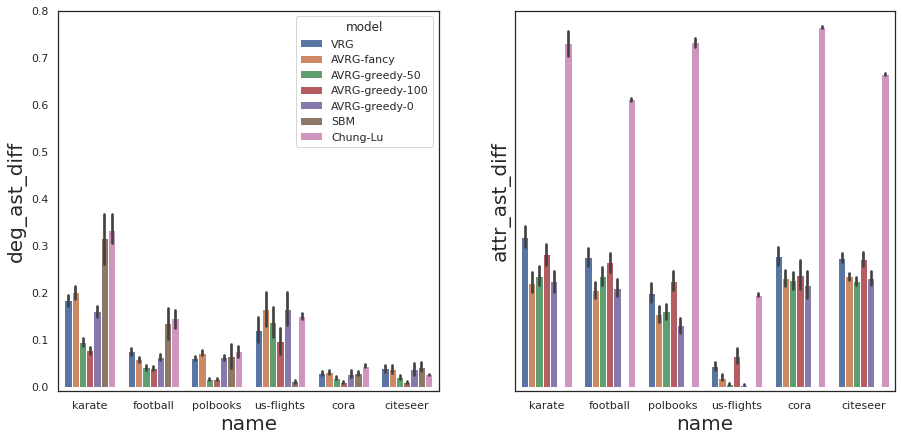

In [65]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
sns.barplot(x='name', y='deg_ast_diff', hue='model', data=graph_df, ax=ax1);
sns.barplot(x='name', y='attr_ast_diff', hue='model', data=graph_df, ax=ax2);
ax1.set_ylim((-0.01, 0.8));
# ax2.set_ylim((0, 0.5));
ax2.legend().set_visible(False);

In [66]:
graph_df[(graph_df.model=='SBM') & (graph_df.name=='cora')]

,name,orig_n,orig_m,orig_degree_ast,attr_name,orig_attr_ast,model,clustering,mu,orig_homophily_ratio,...,gen_attr_ast,total_rewired_edges,fancy_rewired_edges,degree_js,pagerank_js,lambda_dist,deg_ast_diff,attr_ast_diff,gen_homophily_ratio,degree_ast_diff
5030,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.162809,0.244568,0.01870,0.028197,NaN,NaN,-0.028197
5031,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.156538,0.221392,0.02091,0.036826,NaN,NaN,-0.036826
5032,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.166176,0.232816,0.01853,0.028197,NaN,NaN,-0.028197
5033,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.159884,0.226711,0.02086,0.033067,NaN,NaN,-0.033067
5034,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.184036,0.202134,0.02529,0.038307,NaN,NaN,-0.038307
5035,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.151750,0.222189,0.02625,0.020424,NaN,NaN,-0.020424
5036,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.154470,0.217153,0.02637,0.031421,NaN,NaN,-0.031421
5037,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.148019,0.223213,0.01970,0.018254,NaN,NaN,-0.018254
5038,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.178600,0.231012,0.02793,0.032005,NaN,NaN,-0.032005
5039,cora,2485,5069,-0.071365,value,0.763701,SBM,NaN,NaN,0.672385,...,NaN,0,0,0.163922,0.220770,0.02076,0.018302,NaN,NaN,-0.018302


In [ ]:
graph_df.to_csv('./graph_df.csv')

In [ ]:
graph_df = pd.read_csv('./graph_df.csv')

In [ ]:
graph_df['mu'] = graph_df['mu'].astype(int)

In [ ]:
grammar_gen_df = pd.merge(grammar_df, graph_df, on=['name', 'mu', 'clustering'])

In [ ]:
display(grammar_gen_df.head(), grammar_df.shape)

In [ ]:
sns.scatterplot(x='lambda_dist', y='compression', hue='clustering', size='mu', data=grammar_gen_df);

## Spectral and conductance works best

In [ ]:
filtered_df = grammar_gen_df[grammar_gen_df.clustering.isin(('cond', 'spectral', 'leiden'))]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, sharex=True);

sns.barplot(x='mu', y='lambda_dist', hue='clustering', data=filtered_df, ax=ax1);
sns.barplot(x='mu', y='pagerank_js', hue='clustering', data=filtered_df, ax=ax2);
sns.barplot(x='mu', y='compression', hue='clustering', data=filtered_df, ax=ax3);

ax2.set_ylim((0, 1));
ax2.legend().set_visible(False);
ax3.legend().set_visible(False);

## pick mu = 5

### Read different rewired edges

In [ ]:
def make_shuffled_grammar_df():
    frac = np.linspace(0, 100, 11, endpoint=True, dtype=int)    
    shuffle = 'edges'
    names = [f'toy-comm-{f}' for f in frac]
    rows = []
    root_dict = {f'{name}': {} for name in names}
    dl_dict = {}
    
    for name in names:
        orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/{shuffle}/{name}.gexf', node_type=int), 'block'
        dl_dict[name] = graph_mdl(orig_graph)
        if attr_name != '':
            dl_dict[name] = graph_mdl(orig_graph, attributed=True)
    print(dl_dict)
    
    for name in names:
        orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/{shuffle}/{name}.gexf', node_type=int), 'block'
        print('\n\n', name, attr_name)
        for fname in glob.glob(f'/data/ssikdar/attributed-vrg/dumps/grammars/{name}-{shuffle}/*.pkl'):
            path = Path(fname)
            pattern = r'(.*)\_(\w+)\_(\d+)\_(\d+)'
            m = re.match(pattern, path.stem)
            grammar_type, clustering, mu, _ = m.groups()
            
            print(grammar_type, clustering, mu, end='\t', flush=True)
            
            if clustering in root_dict[name]:
                ht, avg_branch_factor, dc = root_dict[name][clustering]
            else:
                root = load_pickle(f'/data/ssikdar/attributed-vrg/dumps/trees/{name}-{shuffle}/{clustering}_list.pkl')
                if isinstance(root, list): root = create_tree(root)
                ht, avg_branch_factor, dc = get_tree_stats(g=orig_graph, root=root)
                root_dict[name][clustering] = ht, avg_branch_factor, dc

            vrg = load_pickle(fname)
#             if grammar_type.startswith('AVRG'): name = f'{name}-attr'
            graph_dl = dl_dict[name]
            
            row = dict(name=name, orig_n=orig_graph.order(), orig_m=orig_graph.size(), attr_name=attr_name, 
                      model=grammar_type, mu=int(mu), clustering=clustering, cost=dc, branch_factor=avg_branch_factor,
                      height=ht, graph_dl=graph_dl, num_rules=vrg.num_rules, unique_rules=len(vrg.unique_rule_list),
                      grammar_dl=vrg.cost)
            name = name.replace('-attr', '')
            rows.append(row)

    return pd.DataFrame(rows)

In [ ]:
shuffled_grammar_df = make_shuffled_grammar_df()

In [ ]:
shuffled_grammar_df['frac'] = shuffled_grammar_df['name'].apply(lambda x: int(x.split('-')[-1]))

In [ ]:
shuffled_grammar_df.head()

In [ ]:
def make_shuffled_graph_df():
    frac = np.linspace(0, 100, 11, endpoint=True, dtype=int)    
    shuffle = 'attrs'
    names = [f'toy-comm-{f}' for f in frac]
    dfs = []
    
#     for name in sorted(names):
    for f, name in zip(frac, names):
#         orig_graph, attr_name = get_graph(name)
        orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/{shuffle}/{name}.gexf', node_type=int), 'block'
        name = f'toy-comm-attrs-{f}'
        print(name)
        for fname in glob.glob(f'/data/ssikdar/attributed-vrg/dumps/graphs/{name}/*'):
            path = Path(fname)
            print(path.stem, end='\t', flush=True)
            pattern = r'(.*)\_(\w+)\_(\d+)\_(\d+)'
            m = re.match(pattern, path.stem)
            grammar_type, clustering, mu, _ = m.groups()
            df = make_graph_df(name, fname, orig_graph, mu, clustering, attr_name, grammar_type)
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
shuffled_graph_df = make_shuffled_graph_df()

In [ ]:
shuffled_graph_df['frac'] = shuffled_graph_df['name'].apply(lambda x: int(x.split('-')[-1]))

In [ ]:
shuffled_graph_df.head()

In [ ]:
shuffled_graph_df = shuffled_graph_df[shuffled_graph_df.model != 'AVRG']

In [ ]:
plt.rcParams['figure.figsize'] = (15, 8)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

sns.lineplot(x='frac', y='orig_degree_ast', marker='o', alpha=0.7, data=shuffled_graph_df, ax=ax1, color='k', label='original');
sns.lineplot(x='frac', y='gen_degree_ast', marker='o', alpha=0.7, ci=90, hue='model', data=shuffled_graph_df, ax=ax1);
ax1.set_ylabel('Degree Assortativity');
ax1.set_xlabel('Fraction');
ax1.set_ylim((-0.05, 0.375));

sns.lineplot(x='frac', y='lambda_dist', marker='o', alpha=0.7, ci=90, hue='model', data=shuffled_graph_df, ax=ax2);
ax2.axhline(0, c='black');
ax2.set_ylabel('Lambda Distance');
ax2.set_xlabel('Fraction');
ax2.set_ylim((-0.05, 0.375));

In [ ]:
plt.rcParams['figure.figsize'] = (20, 8)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

sns.lineplot(x='frac', y='orig_degree_ast', marker='o', alpha=0.7, data=shuffled_graph_df, ax=ax1, color='k', label='original');
sns.lineplot(x='frac', y='gen_degree_ast', marker='o', alpha=0.7, ci=90, hue='model', data=shuffled_graph_df, ax=ax1);
ax1.set_ylabel('Degree Assortativity');
ax1.set_xlabel('Fraction');
ax1.set_ylim((-0.05, 0.375));

sns.lineplot(x='frac', y='orig_attr_ast', marker='o', alpha=0.7, data=shuffled_graph_df, ax=ax2, color='k', label='original');
sns.lineplot(x='frac', y='gen_attr_ast', marker='o', alpha=0.7, ci=90, hue='model', data=shuffled_graph_df, ax=ax2);
ax2.set_ylabel('Attribute Assortativity');
ax2.set_xlabel('Fraction');
ax2.set_ylim((-0.05, 0.95));

sns.lineplot(x='frac', y='lambda_dist', marker='o', alpha=0.7, ci=90, hue='model', data=shuffled_graph_df, ax=ax3);
ax3.axhline(0, c='black');
ax3.set_ylabel('Lambda Distance');
ax3.set_xlabel('Fraction');
ax3.set_ylim((-0.05, 0.95));

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)

sns.lineplot(x='frac', y='orig_degree_ast', marker='o', alpha=0.7, data=shuffled_graph_df, ax=ax1, color='k', label='original');
sns.lineplot(x='frac', y='gen_degree_ast', marker='o', alpha=0.7, ci=90, hue='model', data=shuffled_graph_df, ax=ax1);
ax1.set_ylabel('Degree Assortativity');
ax1.set_xlabel('Fraction');
ax1.set_ylim((-0.05, 0.95));

sns.lineplot(x='frac', y='orig_attr_ast', marker='o', alpha=0.7, data=shuffled_graph_df, ax=ax2, color='k', label='original');
sns.lineplot(x='frac', y='gen_attr_ast', marker='o', alpha=0.7, ci=90, hue='model', data=shuffled_graph_df, ax=ax2);
ax2.set_ylabel('Attribute Assortativity');
ax2.set_xlabel('Fraction');
ax2.set_ylim((-0.05, 0.95));

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

sns.lineplot(x='frac', y='orig_attr_ast', marker='o', alpha=0.7, data=shuffled_graph_df, ax=ax1, color='k', label='original');
sns.lineplot(x='frac', y='gen_attr_ast', marker='o', alpha=0.7, ci=90, hue='model', data=shuffled_graph_df, ax=ax1);
ax1.set_ylabel('Attribute Assortativity');
ax1.set_xlabel('Fraction');

sns.lineplot(x='frac', y='gen_homophily_ratio', marker='o', alpha=0.7, ci=90, hue='model', data=shuffled_graph_df, ax=ax2);
sns.lineplot(x='frac', y='orig_homophily_ratio', marker='o', alpha=0.7, data=shuffled_graph_df, ax=ax2, color='k', label='original');

ax1.set_ylim((0, 1));
ax2.set_ylim((0, 1));
ax2.set_ylabel('Homophily Ratio');
ax2.set_xlabel('Fraction');

In [ ]:
shuffled_graph_df.orig_homophily_ratio

Cora

In [ ]:
! head ../VRG/input/cora/cora/cora.cites

In [ ]:
! head ../VRG/input/cora/cora/cora.content

In [ ]:
! head ../VRG/input/cora/cora/README

In [ ]:
nx_g = nx.Graph()

with open('../VRG/input/cora/cora/cora.cites') as fp:
    for line in fp.readlines():
        u, v = map(int, line.split())
        nx_g.add_edge(u, v)

In [ ]:
print(nx.info(nx_g))

In [ ]:
values = {}

with open('../VRG/input/cora/cora/cora.content') as fp:
    for line in fp.readlines():
        u, *_, cat = line.split()
        values[int(u)] = cat

In [ ]:
len(values)

In [ ]:
nx.set_node_attributes(nx_g, name='value', values=values)

In [ ]:
nx.write_gml(nx_g, '../VRG/input/cora.gml')

## Do the same for attribute shuffled case

In [ ]:
def make_attr_shuffled_graph_df():
    frac = np.linspace(0, 100, 11, endpoint=True, dtype=int)    
    names = [f'toy-comm-{f}-attrs' for f in frac]
    dfs = []

    for f in frac:
        orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/attrs/toy-comm-{f}.gexf', node_type=int), 'block'
        name = f'toy-comm-{f}-attrs'
        print('\n', name, '\n')
        for fname in glob.glob(f'/data/ssikdar/attributed-vrg/dumps/graphs/{name}/*'):
            path = Path(fname)
            print(path.stem, end='\t', flush=True)
            pattern = r'(.*)\_(\w+)\_(\d+)\_(\d+)'
            m = re.match(pattern, path.stem)
            grammar_type, clustering, mu, _ = m.groups()
            df = make_graph_df(name, fname, orig_graph, mu, clustering, attr_name, grammar_type)
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
attr_shuffled_graph_df = make_attr_shuffled_graph_df()

In [ ]:
attr_shuffled_graph_df = attr_shuffled_graph_df[attr_shuffled_graph_df.model != 'AVRG']
attr_shuffled_graph_df['frac'] = attr_shuffled_graph_df['name'].apply(lambda x: int(x.split('-')[-2]))

In [ ]:
attr_shuffled_graph_df.head()

In [ ]:
plt.rcParams['figure.figsize'] = (15, 8)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

sns.lineplot(x='frac', y='orig_degree_ast', marker='o', alpha=0.7, data=attr_shuffled_graph_df, ax=ax1, color='k', label='original');
sns.lineplot(x='frac', y='gen_degree_ast', marker='o', alpha=0.7, ci=None, hue='model', data=attr_shuffled_graph_df, ax=ax1);
ax1.set_ylabel('Degree Assortativity');
ax1.set_xlabel('Fraction');
ax1.set_ylim((-0.05, 1.1));

sns.lineplot(x='frac', y='lambda_dist', marker='o', alpha=0.7, ci=None, hue='model', data=attr_shuffled_graph_df, ax=ax2);
ax2.axhline(0, c='black');
ax2.set_ylabel('Lambda Distance');
ax2.set_xlabel('Fraction');
ax2.set_ylim((-0.05, 1.1));
ax2.legend().set_visible(False);

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

sns.lineplot(x='frac', y='orig_attr_ast', marker='o', alpha=0.7, data=attr_shuffled_graph_df, ax=ax1, color='k', label='original');
sns.lineplot(x='frac', y='gen_attr_ast', marker='o', alpha=0.7, ci=None, hue='model', data=attr_shuffled_graph_df, ax=ax1);
ax1.set_ylabel('Attribute Assortativity');
ax1.set_xlabel('Fraction');
ax1.set_ylim((-0.05, 0.95));

sns.lineplot(x='frac', y='lambda_dist', marker='o', alpha=0.7, ci=None, hue='model', data=attr_shuffled_graph_df, ax=ax2);
ax2.axhline(0, c='black');
ax2.set_ylabel('Lambda Distance');
ax2.set_xlabel('Fraction');
ax2.set_ylim((-0.05, 0.95));
ax2.legend().set_visible(False);

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)

sns.lineplot(x='frac', y='orig_degree_ast', marker='o', alpha=0.7, data=attr_shuffled_graph_df, ax=ax1, color='k', label='original');
sns.lineplot(x='frac', y='gen_degree_ast', marker='o', alpha=0.7, ci=None, hue='model', data=attr_shuffled_graph_df, ax=ax1);
ax1.set_ylabel('Degree Assortativity');
ax1.set_xlabel('Fraction');
ax1.set_ylim((-0.05, 1));

sns.lineplot(x='frac', y='orig_attr_ast', marker='o', alpha=0.7, data=attr_shuffled_graph_df, ax=ax2, color='k', label='original');
sns.lineplot(x='frac', y='gen_attr_ast', marker='o', alpha=0.7, ci=None, hue='model', data=attr_shuffled_graph_df, ax=ax2);
ax2.set_ylabel('Attribute Assortativity');
ax2.set_xlabel('Fraction');
ax2.set_ylim((-0.05, 1));

## Test for bigger datasets

In [ ]:
name = 'pubmed'
g, attr_name = get_graph(name)
ret = get_compatibility_matrix(g, attr_name)

In [ ]:
ret

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

In [ ]:
labels = ret['mapping'].keys()
sns.heatmap(ret['compatibility_mat'], xticklabels=labels, yticklabels=labels, annot=True, fmt='.2g'); 

In [ ]:
nx.degree_assortativity_coefficient(g)

In [ ]:
deg_mixing_mat = nx.degree_mixing_matrix(g, normalized=False)

In [ ]:
deg_mixing_mat.shape

In [ ]:
binned_deg_mix_mat, bound = np.histogram2d(deg_mixing_mat, bins=10)

In [ ]:
binned_deg_mix_mat

In [ ]:
sns.heatmap(binned_deg_mix_mat); 

In [ ]:
sns.scatterplot(x='pagerank_js', y='compression', hue='clustering', size='mu', data=grammar_gen_df);

In [ ]:
sns.scatterplot(x='lambda_dist', y='cost', hue='clustering', size='mu', data=grammar_gen_df);

In [ ]:
sns.scatterplot(x='num_rules', y='compression', hue='clustering', size='mu', data=grammar_gen_df);

In [ ]:
display(graph_df.head(), graph_df.shape)

In [ ]:
import re

In [ ]:
def get_frac(x):
    return int(x.split('-')[-2])

In [ ]:
graph_df['frac'] = graph_df['name'].apply(lambda x: get_frac(x))

In [ ]:
graph_df['frac'].unique()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 6]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax3.set_ylim((-0.1, 4.5))

sns.lineplot(x='frac', y='degree_js', hue='model', data=graph_df, ax=ax1);
sns.lineplot(x='frac', y='pagerank_js', hue='model', data=graph_df, ax=ax2);
sns.lineplot(x='frac', y='lambda_dist', hue='model', data=graph_df, ax=ax3);
ax2.legend().set_visible(False);
ax3.legend().set_visible(False);

In [ ]:
plt.rcParams['figure.figsize'] = [20, 6]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax3.set_ylim((-0.1, 4.5))

sns.boxplot(x='name', y='degree_js', hue='model', data=graph_df, ax=ax1);
sns.boxplot(x='name', y='pagerank_js', hue='model', data=graph_df, ax=ax2);
sns.boxplot(x='name', y='lambda_dist', hue='model', data=graph_df, ax=ax3);
ax2.legend().set_visible(False);
ax3.legend().set_visible(False);

In [ ]:
plt.rcParams['figure.figsize'] = [15, 6]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.set_ylim((-0.1, 1))
ax2.set_ylim((-0.1, 1))

sns.lineplot(x='frac', y='deg_ast_diff', hue='model', data=graph_df, ax=ax1);
sns.lineplot(x='frac', y='attr_ast_diff', hue='model', data=graph_df, ax=ax2);
ax2.legend().set_visible(False);

In [ ]:
plt.rcParams['figure.figsize'] = [20, 6]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

ax1.set_ylim((-0.1, 1))
ax2.set_ylim((-0.1, 1))

sns.boxplot(x='model', y='degree_js', hue='clustering', data=graph_df, ax=ax1);
sns.boxplot(x='model', y='pagerank_js', hue='clustering', data=graph_df, ax=ax2);
sns.boxplot(x='model', y='lambda_dist', hue='clustering', data=graph_df, ax=ax3);
ax2.legend().set_visible(False);
ax3.legend().set_visible(False);

In [ ]:
plt.rcParams['figure.figsize'] = [15, 6]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.set_ylim((-0.1, 1))
ax2.set_ylim((-0.1, 1))

sns.boxplot(x='name', y='deg_ast_diff', hue='model', data=graph_df, ax=ax1);
sns.boxplot(x='name', y='attr_ast_diff', hue='model', data=graph_df, ax=ax2);
ax2.legend().set_visible(False);

In [ ]:
plt.rcParams['figure.figsize'] = [15, 6]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.set_ylim((-0.1, 1))
ax2.set_ylim((-0.1, 1))

sns.boxplot(x='model', y='deg_ast_diff', hue='clustering', data=graph_df, ax=ax1);
sns.boxplot(x='model', y='attr_ast_diff', hue='clustering', data=graph_df, ax=ax2);
ax2.legend().set_visible(False);

----

In [ ]:
# plot out the evolution of the generated graph
gen = load_pickle('/data/ssikdar/attributed-vrg/dumps/generators/karate/AVRG-fancy_cond_5_10.pkl')

In [ ]:
def filter_terminal_graph(graph):
    terminal_nodes = [n for n, d in graph.nodes(data=True) if 'nt' not in d]
    return graph.subgraph(terminal_nodes).copy()

In [ ]:
rows = []
cols = ['snap_id', 'name', 'model', 'clustering', 'attr_name',
        'orig_n', 'orig_m', 'orig_deg_ast', 'orig_att_ast',
        'mu', 'n', 'm', 't', 'term_graph',
        'term_n', 'term_m', 'term_degree_js', 'term_pagerank_js', 'term_lambda_dist',
        'term_deg_ast', 'term_attr_ast']

names = ['karate', 'football', 'polbooks', 'polblogs', 'cora', 'citeseer']
# frac = np.linspace(0, 1, 21, endpoint=True) * 100
# names = [f'3-comm-{int(f)}' for f in frac]
# shuffle = 'edges'

for name in names[3: ]:
    orig_graph, attr_name = get_graph(name)
#     orig_graph, attr_name = nx.read_gexf(f'../VRG/input/shuffled/{shuffle}/{name}.gexf'), 'block'
#     name = f'{name}-{shuffle}'
    orig_deg_ast = nx.degree_assortativity_coefficient(orig_graph)
    if attr_name != '': orig_att_ast = nx.attribute_assortativity_coefficient(orig_graph, attr_name)

    orig_gstats = GraphStats(orig_graph)
    
    for gen_filename in glob.glob(f'/data/ssikdar/attributed-vrg/dumps/generators/{name}/*'):
        path = Path(gen_filename)
        gen = load_pickle(path)

        print(path.stem, end='\t', flush=True)
        pattern = r'(.*)\_(\w+)\_(\d+)\_(\d+)'
        m = re.match(pattern, path.stem)
        grammar_type, clustering, mu, _ = m.groups()
        
        for snap_id, snapshot in enumerate(gen.all_gen_snapshots[::5]):  # do every 5 snapshots
            for t, graph in enumerate(snapshot):
                terminal_graph = filter_terminal_graph(graph)
                terminal_graph = un_nest_attr_dict(terminal_graph)
                row = {col: np.nan for col in cols}

                row.update(dict(snap_id=snap_id, name=gen.grammar.name, 
                           model=grammar_type, clustering=clustering, attr_name=attr_name,
                           orig_n=orig_graph.order(), orig_m=orig_graph.size(),
                           orig_deg_ast=orig_deg_ast, orig_att_ast=orig_att_ast,
                           mu=gen.grammar.mu, t=t, n=graph.order(), m=graph.size(), term_graph=terminal_graph,
                           term_n=terminal_graph.order(), term_m=terminal_graph.size()))
                
                if terminal_graph.size() > 0:
                    gen_gstats = GraphStats(terminal_graph)

                    gpc = GraphPairCompare(orig_gstats, gen_gstats)
                    row.update(term_degree_js=gpc.degree_js(), term_pagerank_js=gpc.pagerank_js(), 
                               term_lambda_dist=gpc.lambda_dist(), 
                               term_deg_ast=nx.degree_assortativity_coefficient(terminal_graph),
                               term_att_ast=nx.attribute_assortativity_coefficient(terminal_graph, attr_name))
                rows.append(row)
    temp_df = pd.DataFrame(rows)
    temp_df.to_csv('/data/ssikdar/attributed-vrg/data/temp_gen_df.csv', index=False)
gen_df2 = pd.DataFrame(rows)

In [ ]:
gen_df.to_csv('/data/ssikdar/attributed-vrg/data/gen_df_big.csv', index=False)

In [ ]:
gen_df = pd.concat([gen_df, gen_df2], ignore_index=True)

In [ ]:
gen_df.head()

In [ ]:
gen_df['term_attr_ast'] = gen_df['term_graph'].apply(lambda g: nx.attribute_assortativity_coefficient(g, 'value'))

In [ ]:
gen_df['term_frac_m'] = gen_df['term_m'] / gen_df['orig_m']

In [ ]:
gen_df.to_csv('/data/ssikdar/attributed-vrg/data/gen_df.csv', index=False)

In [ ]:
gen_df = pd.read_csv('/data/ssikdar/attributed-vrg/data/gen_df.csv')

In [ ]:
display(gen_df.head(), gen_df.shape)

In [ ]:
plt.rcParams['figure.figsize'] = [15, 20]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1)

# ax1.set_ylim((-0.1, 1))
# ax2.set_ylim((-0.1, 1))
# ax1.set_ylim((-0.1, 1.05))
ax1.axhline(1, c='k')

sns.lineplot(x='t', y='term_frac_m', hue='model', marker='o', data=gen_df, ax=ax1);
sns.lineplot(x='t', y='term_lambda_dist', hue='model', marker='o', data=gen_df, ax=ax2);
sns.lineplot(x='t', y='term_deg_ast', hue='model', marker='o', data=gen_df, ax=ax3);
sns.lineplot(x='t', y='term_attr_ast', hue='model', marker='o', data=gen_df, ax=ax4);

In [ ]:
def group_plot(df):
    metrics = ['term_n', 'term_degree_js', 'term_pagerank_js', 'term_lambda_dist', 'term_deg_ast', 'term_att_ast'][-2: ]
    rows = len(metrics)
    
    names = df.name.unique() # ['karate', 'football']
    cols = len(names)

    l_d_min = min(df[df.name==name].term_lambda_dist.min() for name in names) - 0.1
    l_d_max = max(df[df.name==name].term_lambda_dist.max() for name in names) + 2
    
    plt.rcParams['figure.figsize'] = [20, 12]
#     plt.rcParams['figure.figsize'] = [20, 12]
    fig, axes = plt.subplots(nrows=rows, ncols=cols,)

    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            metric = metrics[i]
            name = names[j]
            filtered_df = df[df.name==name]
            
            if i == 0 and j == 0:
                legend_style = 'brief'
            else:
                legend_style = ''
            
#             ax.set_xscale('log')
            sns.lineplot(x='t', y=metric, ax=ax, data=filtered_df, alpha=0.85,
                         hue='model', marker='o', ci=99, err_style='band', legend=legend_style);
            
            if 'js' in metric:
                ax.set_ylim((-0.05, 1.1))
            elif 'lambda_dist' in metric:
                ax.set_ylim((-1, 5))
            elif 'ast' in metric:
                ax.set_ylim((-1.05, 1.05))
                
            if 'deg_ast' in metric:
                ax.axhline(filtered_df.orig_deg_ast.mean())
            if 'att_ast' in metric:
                ax.axhline(filtered_df.orig_att_ast.mean())
            if 'term_n' in metric:
                ax.axhline(filtered_df.orig_n.mean())
            
            if j == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')
                
            if i == 0:
                ax.set_title(name)
            else:
                ax.set_title('')
                
            if i == rows - 1:
                ax.set_xlabel('t')
            else:
                ax.set_xlabel('')
            
#     plt.suptitle(f'{name}', y=1.01);
    plt.tight_layout()

In [ ]:
gen_df.name.unique()

In [ ]:
group_plot(gen_df)

In [ ]:
# plot dasgupta cost v. graph quality
# diversity of output graphs - APL v CC / PGD PCA 

## CABAM stuff

In [ ]:
def make_cabam_graph_df():
    input_graphs = read_cabam_graphs()
    
    dfs = []
    attr_name = 'value'
    for i, orig_graph in enumerate(input_graphs):
        name = f'CABAM-{i}'
        print('\n', name, '\n')
        for fname in glob.glob(f'/data/ssikdar/attributed-vrg/dumps/graphs/CABAM/*_{i}.pkl'):
            path = Path(fname)
            grammar_type, clustering, mu, _, idx = path.stem.split('_')
            mu, idx = int(mu), int(idx)
            assert idx == i
            print(path.stem, end='\t', flush=True)

            df = make_graph_df(name, fname, orig_graph, mu, clustering, attr_name, grammar_type)
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
cabam_df = make_cabam_graph_df()

In [ ]:
cabam_df['i'] = cabam_df['name'].apply(lambda x: int(x.split('-')[-1]))

In [ ]:
cabam_df.model.unique()

In [ ]:
cabam_df['model'].replace(['AVRG-greedy-0-50', 'AVRG-greedy-0-50-100'], ['AVRG-greedy-50', 'AVRG-greedy-100'], inplace=True)

In [ ]:
cabam_df.to_csv('/data/ssikdar/attributed-vrg/data/cabam.csv', index=False)

In [ ]:
plt.rcParams['figure.figsize'] = [20, 6]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

ax1.set_ylim((-0.1, 0.5))
ax2.set_ylim((-0.1, 0.5))
ax3.set_ylim((-0.1, 0.5))

sns.lineplot(x='i', y='degree_js', hue='model', marker='o', data=cabam_df, ax=ax1);
sns.lineplot(x='i', y='pagerank_js', hue='model', marker='o', data=cabam_df, ax=ax2);
sns.lineplot(x='i', y='lambda_dist', hue='model', marker='o', data=cabam_df, ax=ax3);
ax2.legend().set_visible(False);
ax3.legend().set_visible(False);

In [ ]:
plt.rcParams['figure.figsize'] = [15, 6]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.set_ylim((-1, 1.1))
ax2.set_ylim((-1, 1.1))

sns.lineplot(x='i', y='orig_degree_ast', marker='o', color='k', data=cabam_df, ax=ax1, label='original');
sns.lineplot(x='i', y='gen_degree_ast', marker='o', hue='model', data=cabam_df, ax=ax1);

sns.lineplot(x='i', y='orig_attr_ast', marker='o', color='k', data=cabam_df, ax=ax2, label='original');
sns.lineplot(x='i', y='gen_attr_ast', marker='o', hue='model', data=cabam_df, ax=ax2);

ax2.legend().set_visible(False);

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
ax = plt.gca()

ax.set_ylim((-1, 1.1));
df = cabam_df[cabam_df.model.isin((['AVRG-greedy-0', ]))] # , 'AVRG-greedy-50', 'AVRG-greedy-100'))]
sns.lineplot(x='i', y='orig_attr_ast', marker='o', color='k', data=df, ax=ax, label='original');
sns.lineplot(x='i', y='gen_attr_ast', marker='o', hue='clustering', data=df, ax=ax);